## Verifying Exception Cases of OCED PFAS in Merged Dataset

In [ ]:
import pandas as pd

with open("/teamspace/studios/this_studio/files/merged_massspec_nist20_mona_fold.tsv", "r") as f:
    df_merged = pd.read_csv(f, sep='\t')

df_merged.head(3)

In [4]:
from rdkit import Chem
from rdkit.Chem import rdchem

# Definition of PFAS  based on OECD: https://pubs.acs.org/doi/10.1021/acs.est.1c06896
def is_pfas(smiles: str) -> int:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0

        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() != 6:  # carbon only
                continue

            # neighbors
            neigh = atom.GetNeighbors()
            sym = [n.GetSymbol() for n in neigh]

            num_F = sum(1 for s in sym if s == "F")
            has_X  = any(s in ("Cl", "Br", "I") for s in sym)
            has_H  = atom.GetTotalNumHs() > 0  # implicit + explicit Hs

            # require sp3 and all single bonds (rules out alkenes like TFE)
            is_sp3 = atom.GetHybridization() == rdchem.HybridizationType.SP3
            all_single = all(
                mol.GetBondBetweenAtoms(atom.GetIdx(), n.GetIdx()).GetBondType() == rdchem.BondType.SINGLE
                for n in neigh
            )

            # CF3: at least 3 F neighbors; CF2: at least 2 F neighbors
            if (num_F >= 3 or num_F >= 2) and is_sp3 and all_single and not has_H and not has_X:
                # For CF2, make sure there's at least one non-F neighbor so it's truly "-CF2-"
                if num_F >= 3:
                    return 1
                else:  # CF2
                    nonF_neighbors = sum(1 for s in sym if s != "F")
                    if nonF_neighbors >= 1:  # "-CF2-" has something other than F attached
                        return 1

        return 0
    except Exception:
        return 0


In [ ]:
df_merged["is_pfas"] = df_merged["smiles"].apply(is_pfas)
pfas_df = df_merged[df_merged["is_pfas"] == 1]
df_train = pfas_df[pfas_df["fold"] == "train"]
print("train PFAS spectra " + str(len(df_train)))
df_val = pfas_df[pfas_df["fold"] == "val"]
print("val PFAS spectra " + str(len(df_val)))

In [ ]:
print("train PFAS spectra " + str(df_train["smiles"].nunique()))
print("val PFAS spectra " + str(df_val["smiles"].nunique()))

In [ ]:
#pfas #1
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# Select 10 PFAS molecules at random
pfas_sample = df_merged.loc[df_merged["is_pfas"] == 1, "smiles"].sample(n=50, random_state=42)

# Build dataframe with SMILES + RDKit Mol
pfas_selected = []
for smi in pfas_sample:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        pfas_selected.append({"smiles": smi, "mol": mol})

pfas_df = pd.DataFrame(pfas_selected)

# Function to draw molecules in batches of 5
def draw_batch(df, start_idx, batch_size=5):
    subset = df.iloc[start_idx:start_idx+batch_size]
    mols = subset["mol"].tolist()
    legends = subset["smiles"].tolist()
    return Draw.MolsToGridImage(mols, molsPerRow=batch_size, subImgSize=(300,300), legends=legends)

# Example usage:
img1 = draw_batch(pfas_df, 0)   # first 5
img2 = draw_batch(pfas_df, 5)   # next 5
img3 = draw_batch(pfas_df, 10)
img4 = draw_batch(pfas_df, 49)
img1


In [ ]:
#non-pfas #1
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# Filter non-PFAS molecules, remove duplicates
non_pfas = df_merged.loc[df_merged["is_pfas"] == 0, "smiles"].drop_duplicates()

selected = []

for smi in non_pfas:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        # Count fluorine atoms
        fluorine_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == "F")
        if fluorine_count > 1:
            selected.append({"smiles": smi, "mol": mol, "fluorine_count": fluorine_count})
    if len(selected) == 30:
        break

# Put into a dataframe
selected_df = pd.DataFrame(selected)

# Function to draw 5 molecules at a time
def draw_batch(df, start_idx, batch_size=5):
    subset = df.iloc[start_idx:start_idx+batch_size]
    mols = subset["mol"].tolist()
    legends = [f"{row.smiles} | F count: {row.fluorine_count}" for row in subset.itertuples()]
    return Draw.MolsToGridImage(mols, molsPerRow=batch_size, subImgSize=(300,300), legends=legends)

# Example: draw first batch (5 molecules)
img1 = draw_batch(selected_df, 0)
img2 = draw_batch(selected_df, 5)
img3 = draw_batch(selected_df, 10)
img4 = draw_batch(selected_df, 15)
img1

In [ ]:

# --- Step 1: Identify Negatives ---
neg_df = df_preds[df_preds["is_PFAS"] == 0].copy()

print(f"Negatives: {len(neg_df)}")

# --- Step 2: Filter Negatives that contain Fluorine ---
# You can check SMILES string
hard_neg_with_fluorine = neg_df[
    neg_df["smiles"].str.contains("F", case=False, na=False)
].copy()

print(f"Hard Negatives containing Fluorine: {len(hard_neg_with_fluorine)}")

# --- Step 3: Group by training/validation fold ---
summary_by_fold = (
    hard_neg_with_fluorine.groupby("fold")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print("\n📊 Hard Negatives with Fluorine by Fold:")
print(summary_by_fold.to_string(index=False))

# --- Step 4: (Optional) Inspect a few examples from each ---
for fold_name, subset in hard_neg_with_fluorine.groupby("fold"):
    print(f"\n=== {fold_name.upper()} SET ===")
    display(subset[["identifier", "formula", "smiles"]].head(10))

# --- Step 5: Save for further analysis ---
hard_neg_with_fluorine.to_csv("hard_negatives_with_fluorine_by_fold.csv", index=False)
print("\n✅ Saved hard negatives with fluorine → hard_negatives_with_fluorine_by_fold.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your file (adjust path and separator)
df = pd.read_csv("/teamspace/studios/this_studio/MassSpecGym/scripts/pfas_pred_probs.csv")  # or sep="\t" if TSV

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["pred_prob"], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Predicted Probabilities (PFAS = 1)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


## Understanding FN with prob <= 0.25

In [1]:
#loadng df
import pandas as pd
df = pd.read_csv('/teamspace/studios/this_studio/files/merged_massspec_nist20_nist_new_with_pfas_fold.tsv', sep='\t')

/tmp/ipykernel_1850/1853820480.py:3: DtypeWarning: Columns (7,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/teamspace/studios/this_studio/files/merged_massspec_nist20_nist_new_with_pfas_fold.tsv', sep='\t')


In [2]:
df.head(1)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,identifier,mzs,intensities,smiles,inchikey,formula,precursor_formula,parent_mass,precursor_mz,adduct,instrument_type,collision_energy,fold,simulation_challenge,name,is_PFAS
0,0,0,0,MassSpecGymID0000001,"91.0542,125.0233,154.0499,155.0577,185.0961,20...","0.24524524524524524,1.0,0.08008008008008008,0....",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,VFMQMACUYWGDOJ,C16H17NO4,C16H18NO4,287.115224,288.1225,[M+H]+,Orbitrap,30.0,train,True,NaN,0


### False Negative

In [3]:
import re

false_neg_ids = []

with open('/teamspace/studios/this_studio/MassSpecGym/scripts/false_negative_identifiers.txt', "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # skip empty lines
        # Remove leading number + dot (e.g., "1. ", "10. ", etc.)
        cleaned_line = re.sub(r'^\d+\.\s*', '', line)
        false_neg_ids.append(cleaned_line)

In [4]:
results = []

for ident in false_neg_ids:
    match = df[df['identifier'] == ident]
    if not match.empty:
        smiles = match.iloc[0]['smiles']
    else:
        smiles = None 
    results.append({'identifier': ident, 'smiles': smiles})
false_neg_ids_smiles_df = pd.DataFrame(results)

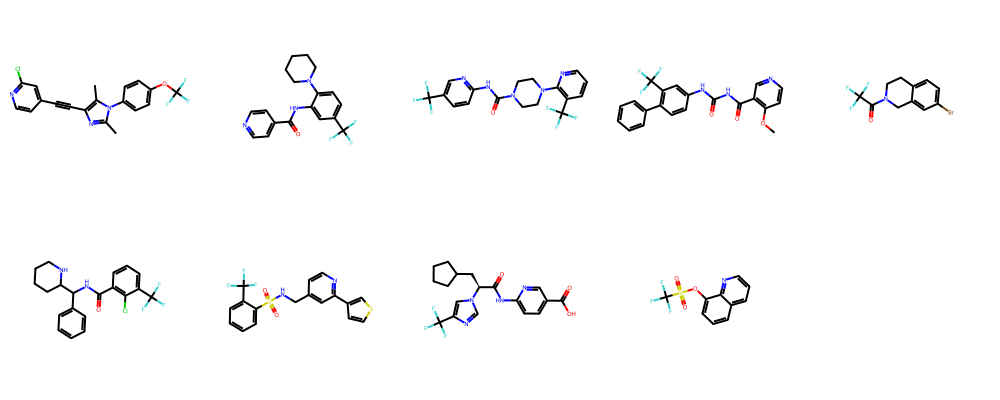

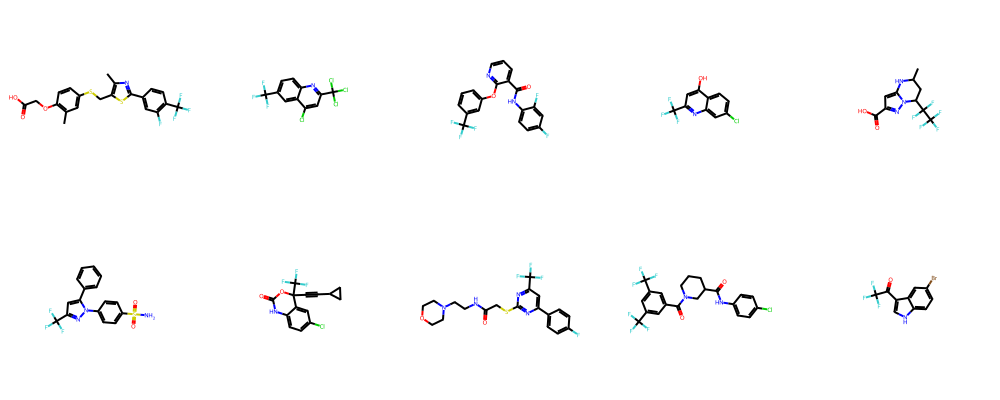

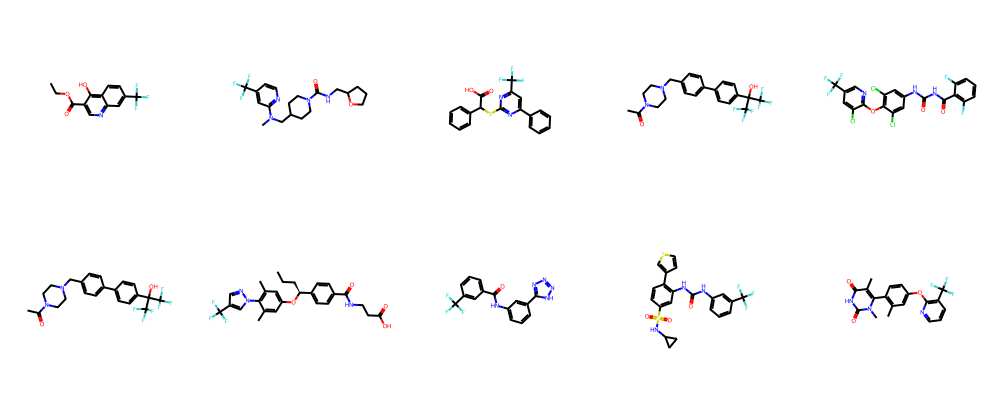

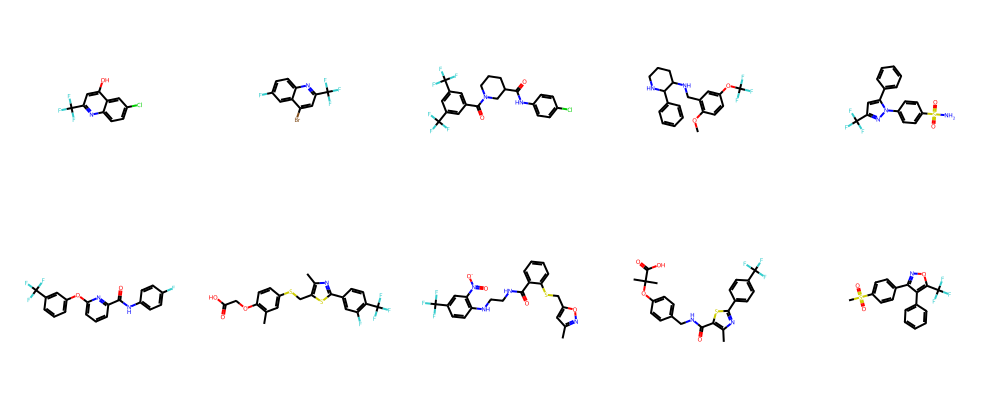

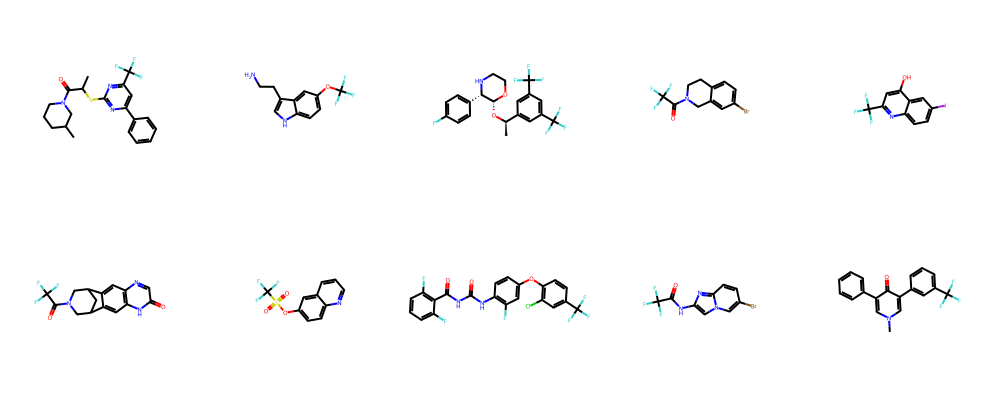

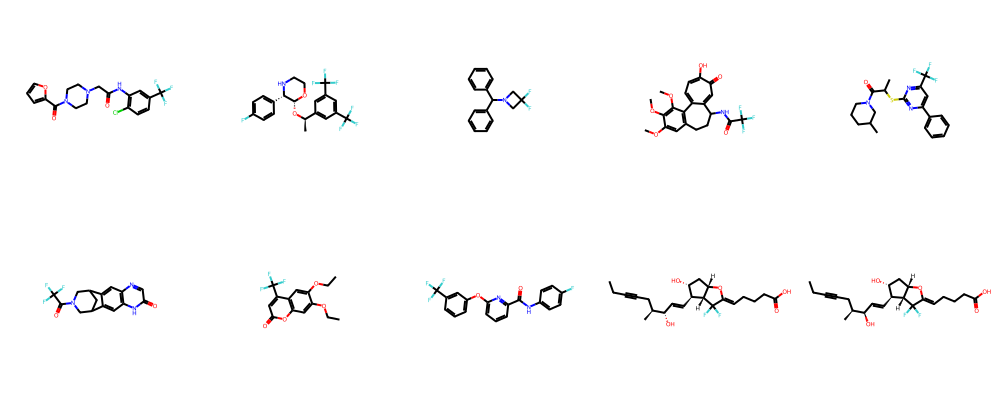

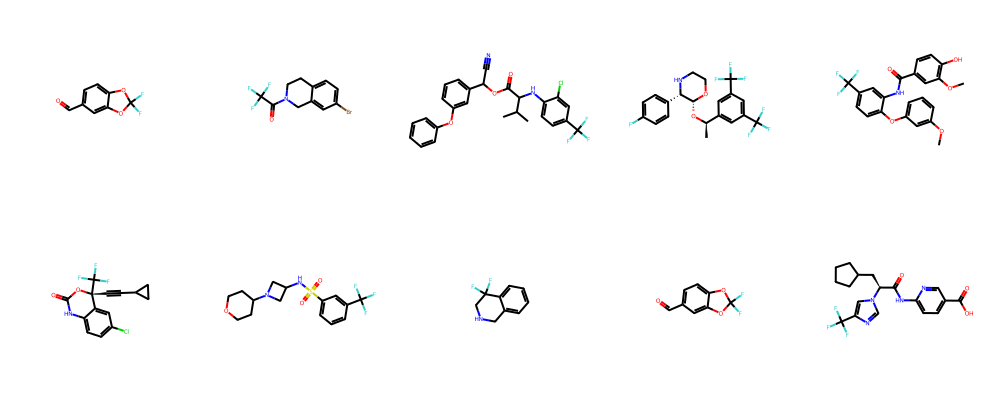

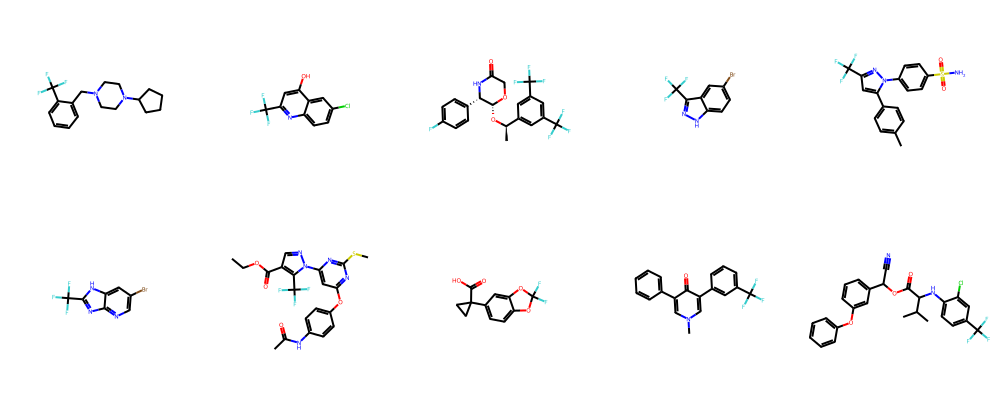

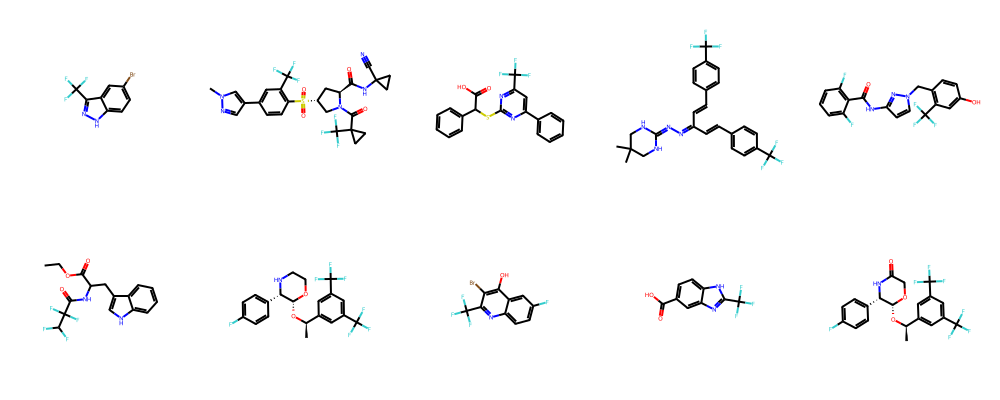

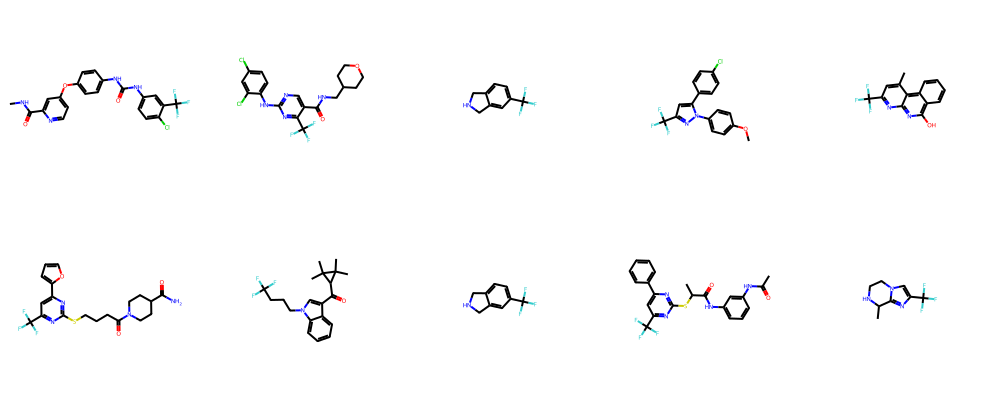

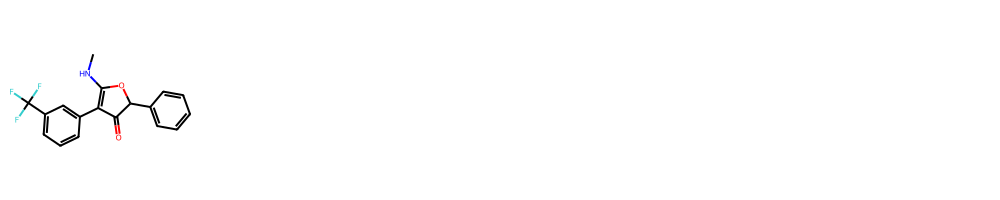

In [5]:
#drawing all 100
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

batch_size = 10

# Assume your DataFrame is named false_neg_ids_smiles_df and has a 'smiles' column
smiles_list = false_neg_ids_smiles_df['smiles'].tolist()

for i in range(0, len(smiles_list), batch_size):
    batch = smiles_list[i:i + batch_size]
    
    # Convert smiles to RDKit Mol objects, skip invalid smiles
    mols = [Chem.MolFromSmiles(s) for s in batch if s is not None]

    # Draw grid image for this batch
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
    
    # Display the image in Jupyter notebook or IPython
    display(img)


In [ ]:
#random 50
import random
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# --- Step 1: Prepare your SMILES list ---
smiles_list_all = false_neg_ids_smiles_df["smiles"].dropna().unique().tolist()

# --- Step 2: Select first 25 random SMILES ---
random.seed(42)
smiles_list_false_neg_1 = random.sample(smiles_list_all, 25)

# --- Step 3: Select another 25 random SMILES with no overlap ---
remaining_smiles = list(set(smiles_list_all) - set(smiles_list_false_neg_1))
random.seed(43)
smiles_list_false_neg_2 = random.sample(remaining_smiles, 25)

# --- Step 4: Define function to draw molecules ---
def draw_smiles_list(smiles_list, title="Molecules"):
    mols = [Chem.MolFromSmiles(s) for s in smiles_list if Chem.MolFromSmiles(s)]
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
    display(img)

# --- Step 5: Draw both batches ---
print("Batch 1 (First 25):")
draw_smiles_list(smiles_list_false_neg_1)

print("Batch 2 (Second 25, distinct):")
draw_smiles_list(smiles_list_false_neg_2)


### Molecular Weight

In [ ]:
# Molecular Weight

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# Compute molecular descriptors
data = []
for smi in results:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        data.append({
            "SMILES": smi,
            "MolWt": round(Descriptors.MolWt(mol), 2),
            "NumRings": rdMolDescriptors.CalcNumRings(mol),
            "NumF": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "F"),
            "NumCl": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "Cl"),
            "NumBr": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "Br"),
            "NumO": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "O"),
            "NumN": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "N"),
            "NumS": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "S"),
            "TPSA": round(Descriptors.TPSA(mol), 2),
            "LogP": round(Descriptors.MolLogP(mol), 2),
        })
    else:
        data.append({"SMILES": smi, "MolWt": None})

# Convert to DataFrame
df_false_neg = pd.DataFrame(data)

# Display and export
df_false_neg.head(10)

### Structural Similarity

In [ ]:
#Structural Similarity Analysis for PFAS False Negative 

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import FingerprintSimilarity
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# --- Use your existing variable ---
# Ensure this variable is already defined before running:
# random_25_smiles_false = [ 'Cc1nc2cc(F)ccc2[nH]1', ... ]
smiles_list = results

# --- Step 1: Convert SMILES to RDKit Mol objects ---
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list if Chem.MolFromSmiles(smi)]

# --- Step 2: Generate Morgan Fingerprints (circular fingerprints, radius=2) ---
fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=1024) for m in mols]

# --- Step 3: Compute Pairwise Tanimoto Similarity ---
n = len(fps)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        sim = FingerprintSimilarity(fps[i], fps[j])
        sim_matrix[i, j] = sim_matrix[j, i] = sim

# --- Step 4: Hierarchical Clustering (based on distance = 1 - similarity) ---
clusterer = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='average')
labels = clusterer.fit_predict(1 - sim_matrix)

# --- Step 5: Visualize Similarity Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap='viridis')
plt.title("Tanimoto Structural Similarity (25 False Negatives)")
plt.xlabel("Molecule Index")
plt.ylabel("Molecule Index")
plt.show()

# --- Step 6: Export Results ---
df_sim = pd.DataFrame(sim_matrix, 
                      columns=[f"Mol_{i}" for i in range(n)], 
                      index=[f"Mol_{i}" for i in range(n)])
df_labels = pd.DataFrame({"SMILES": smiles_list, "Cluster": labels})


### Functional Group

In [ ]:
#Functional Group

# --- Functional Group Analysis for PFAS False Negatives ---
# Requirements:
# !pip install rdkit-pypi pandas seaborn matplotlib

from rdkit import Chem
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Use your variable from before ---
# random_25_smiles_false = [...]

smiles_list = random_25_smiles_false

# --- Define Functional Groups via SMARTS patterns ---
functional_groups = {
    "carboxylic_acid": "C(=O)[OH]",
    "ester": "C(=O)O[C,c]",
    "amide": "C(=O)N",
    "amine_primary": "[NH2]",
    "amine_secondary": "[NH][C]",
    "alcohol": "[CX4][OH]",
    "phenol": "c[OH]",
    "ether": "C-O-C",
    "sulfonamide": "S(=O)(=O)N",
    "sulfonic_acid": "S(=O)(=O)[OH]",
    "halogen": "[F,Cl,Br,I]",
    "fluoro_alkyl": "C(F)(F)F",
    "nitro": "[NX3](=O)=O",
    "carbonyl": "C=O",
    "aromatic_ring": "a1aaaaa1"
}

# Convert SMARTS to RDKit Mol objects
smarts_mols = {name: Chem.MolFromSmarts(sma) for name, sma in functional_groups.items()}

# --- Analyze Each Molecule ---
records = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue

    result = {"SMILES": smi}
    for name, pattern in smarts_mols.items():
        result[name] = int(mol.HasSubstructMatch(pattern))
    records.append(result)

# --- Results to DataFrame ---
df_fg = pd.DataFrame(records)
df_fg.set_index("SMILES", inplace=True)

# --- Summarize Functional Group Prevalence ---
summary = df_fg.sum().sort_values(ascending=False)
print("\nFunctional Group Frequency:")
print(summary)

# --- Visualization ---
plt.figure(figsize=(10, 5))
sns.barplot(x=summary.index, y=summary.values)
plt.xticks(rotation=60, ha='right')
plt.title("Functional Group Frequency in False Negatives")
plt.ylabel("Count of Molecules Containing Group")
plt.xlabel("Functional Group")
plt.tight_layout()
plt.show()

### Location and Num of Fluorine

In [ ]:
#Location and Num of Fluorine
from rdkit imp
import pandas as pd

smiles_list = random_25_smiles_false  # your new list

def fluorine_analysis(mol):
    """
    Count total fluorines, aromatic F, aliphatic F,
    and record atom indices for all fluorines.
    """
    f_atoms = [a for a in mol.GetAtoms() if a.GetSymbol() == "F"]
    total_f = len(f_atoms)
    aromatic_f = sum(1 for a in f_atoms if a.GetIsAromatic())
    aliphatic_f = total_f - aromatic_f
    positions = [a.GetIdx() for a in f_atoms]  # atom indices of F
    return total_f, aromatic_f, aliphatic_f, positions

records = []

for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Skipping invalid SMILES: {smi}")
        continue
    
    total_f, arom_f, alip_f, positions = fluorine_analysis(mol)
    
    records.append({
        "SMILES": smi,
        "Total_F": total_f,
        "Aromatic_F": arom_f,
        "Aliphatic_F": alip_f,
        "F_atom_indices": positions
    })

# Convert to DataFrame
df_fluorine = pd.DataFrame(records)

# Optional: show only molecules with at least 1 fluorine
df_with_f = df_fluorine[df_fluorine["Total_F"] > 0]

df_with_f


## True Positive

In [51]:
import re

true_pos_ids = []

with open('/teamspace/studios/this_studio/MassSpecGym/scripts/true_positive_identifiers.txt', "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # skip empty lines
        # Remove leading number + dot (e.g., "1. ", "10. ", etc.)
        cleaned_line = re.sub(r'^\d+\.\s*', '', line)
        true_pos_ids.append(cleaned_line)

In [52]:
results_2 = []

for ident in true_pos_ids:
    match = df[df['identifier'] == ident]
    if not match.empty:
        smiles = match.iloc[0]['smiles']
    else:
        smiles = None 
    results_2.append({'identifier': ident, 'smiles': smiles})
true_pos_ids_smiles_df = pd.DataFrame(results_2)

In [ ]:
true_pos_ids_smiles_df

In [ ]:
#drawing all 100
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

batch_size = 10

# Assume your DataFrame is named true_pos_ids_smiles_df and has a 'smiles' column
smiles_list = true_pos_ids_smiles_df['smiles'].tolist()

for i in range(0, len(smiles_list), batch_size):
    batch = smiles_list[i:i + batch_size]
    
    # Convert smiles to RDKit Mol objects, skip invalid smiles
    mols = [Chem.MolFromSmiles(s) for s in batch if s is not None]

    # Draw grid image for this batch
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
    
    # Display the image in Jupyter notebook or IPython
    display(img)


In [ ]:
import random
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# --- Step 1: Prepare your SMILES list ---
smiles_list_true_pos = true_pos_ids_smiles_df["smiles"].dropna().tolist()

# --- Step 2: Select the first 25 random SMILES (fixed with a random seed) ---
random.seed(42)
random_25_smiles_true = random.sample(smiles_list_true_pos, 25)

# --- Step 3: Select another 25 random SMILES with no overlap ---
remaining_smiles = list(set(smiles_list_true_pos) - set(random_25_smiles_true))

random.seed(43)
random_25_smiles_true_2 = random.sample(remaining_smiles, 25)

# --- Step 4: Define a function to draw molecules in a grid ---
def draw_smiles_list(smiles_list, title="Molecules"):
    mols = [Chem.MolFromSmiles(s) for s in smiles_list if s is not None]
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
    display(img)

# --- Step 5: Draw both batches ---
print("Batch 1 (First 25):")
draw_smiles_list(random_25_smiles_true)

print("Batch 2 (Second 25, distinct):")
draw_smiles_list(random_25_smiles_true_2)


### 3F + 2F 

In [ ]:
for i in range(0, len(random_25_smiles_true), batch_size):
    batch = random_25_smiles_true[i:i + batch_size]
    
    # Convert smiles to RDKit Mol objects, skip invalid smiles
    mols = [Chem.MolFromSmiles(s) for s in batch if s is not None]

    # Draw grid image for this batch
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
    
    # Display the image in Jupyter notebook or IPython
    display(img)


### Molecular Weight

In [ ]:
# Molecular Weight

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# Compute molecular descriptors
data = []
for smi in random_25_smiles_true:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        data.append({
            "SMILES": smi,
            "MolWt": round(Descriptors.MolWt(mol), 2),
            "NumRings": rdMolDescriptors.CalcNumRings(mol),
            "NumF": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "F"),
            "NumCl": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "Cl"),
            "NumBr": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "Br"),
            "NumO": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "O"),
            "NumN": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "N"),
            "NumS": sum(1 for a in mol.GetAtoms() if a.GetSymbol() == "S"),
            "TPSA": round(Descriptors.TPSA(mol), 2),
            "LogP": round(Descriptors.MolLogP(mol), 2),
        })
    else:
        data.append({"SMILES": smi, "MolWt": None})

# Convert to DataFrame
df_false_pos = pd.DataFrame(data)

# Display and export
df_false_pos.head(10)



### Strucutral Similarity

In [ ]:
#Structural Similarity Analysis for PFAS True Posisive 

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import FingerprintSimilarity
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# --- Use your existing variable ---
# Ensure this variable is already defined before running:
# random_25_smiles_false = [ 'Cc1nc2cc(F)ccc2[nH]1', ... ]
smiles_list = random_25_smiles_true

# --- Step 1: Convert SMILES to RDKit Mol objects ---
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list if Chem.MolFromSmiles(smi)]

# --- Step 2: Generate Morgan Fingerprints (circular fingerprints, radius=2) ---
fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=1024) for m in mols]

# --- Step 3: Compute Pairwise Tanimoto Similarity ---
n = len(fps)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        sim = FingerprintSimilarity(fps[i], fps[j])
        sim_matrix[i, j] = sim_matrix[j, i] = sim

# --- Step 4: Hierarchical Clustering (based on distance = 1 - similarity) ---
clusterer = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='average')
labels = clusterer.fit_predict(1 - sim_matrix)

# --- Step 5: Visualize Similarity Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap='viridis')
plt.title("Tanimoto Structural Similarity (25 False Negatives)")
plt.xlabel("Molecule Index")
plt.ylabel("Molecule Index")
plt.show()

# --- Step 6: Export Results ---
df_sim = pd.DataFrame(sim_matrix, 
                      columns=[f"Mol_{i}" for i in range(n)], 
                      index=[f"Mol_{i}" for i in range(n)])
df_labels = pd.DataFrame({"SMILES": smiles_list, "Cluster": labels})


### Functional Group

In [ ]:
#Functional Group

# --- Functional Group Analysis for PFAS False Negatives ---
# Requirements:
# !pip install rdkit-pypi pandas seaborn matplotlib

from rdkit import Chem
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Use your variable from before ---
# random_25_smiles_false = [...]

smiles_list = random_25_smiles_true

# --- Define Functional Groups via SMARTS patterns ---
functional_groups = {
    "carboxylic_acid": "C(=O)[OH]",
    "ester": "C(=O)O[C,c]",
    "amide": "C(=O)N",
    "amine_primary": "[NH2]",
    "amine_secondary": "[NH][C]",
    "alcohol": "[CX4][OH]",
    "phenol": "c[OH]",
    "ether": "C-O-C",
    "sulfonamide": "S(=O)(=O)N",
    "sulfonic_acid": "S(=O)(=O)[OH]",
    "halogen": "[F,Cl,Br,I]",
    "fluoro_alkyl": "C(F)(F)F",
    "nitro": "[NX3](=O)=O",
    "carbonyl": "C=O",
    "aromatic_ring": "a1aaaaa1"
}

# Convert SMARTS to RDKit Mol objects
smarts_mols = {name: Chem.MolFromSmarts(sma) for name, sma in functional_groups.items()}

# --- Analyze Each Molecule ---
records = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue

    result = {"SMILES": smi}
    for name, pattern in smarts_mols.items():
        result[name] = int(mol.HasSubstructMatch(pattern))
    records.append(result)

# --- Results to DataFrame ---
df_fg = pd.DataFrame(records)
df_fg.set_index("SMILES", inplace=True)

# --- Summarize Functional Group Prevalence ---
summary = df_fg.sum().sort_values(ascending=False)
print("\nFunctional Group Frequency:")
print(summary)

# --- Visualization ---
plt.figure(figsize=(10, 5))
sns.barplot(x=summary.index, y=summary.values)
plt.xticks(rotation=60, ha='right')
plt.title("Functional Group Frequency in False Negatives")
plt.ylabel("Count of Molecules Containing Group")
plt.xlabel("Functional Group")
plt.tight_layout()
plt.show()


### Location + Num Fluorine

In [ ]:
#Location & Num of Fluorine
from rdkit import Chem
import pandas as pd

smiles_list = random_25_smiles_true  # your new list

def fluorine_analysis(mol):
    """
    Count total fluorines, aromatic F, aliphatic F,
    and record atom indices for all fluorines.
    """
    f_atoms = [a for a in mol.GetAtoms() if a.GetSymbol() == "F"]
    total_f = len(f_atoms)
    aromatic_f = sum(1 for a in f_atoms if a.GetIsAromatic())
    aliphatic_f = total_f - aromatic_f
    positions = [a.GetIdx() for a in f_atoms]  # atom indices of F
    return total_f, aromatic_f, aliphatic_f, positions

records = []

for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Skipping invalid SMILES: {smi}")
        continue
    
    total_f, arom_f, alip_f, positions = fluorine_analysis(mol)
    
    records.append({
        "SMILES": smi,
        "Total_F": total_f,
        "Aromatic_F": arom_f,
        "Aliphatic_F": alip_f,
        "F_atom_indices": positions
    })

# Convert to DataFrame
df_fluorine = pd.DataFrame(records)

# Optional: show only molecules with at least 1 fluorine
df_with_f = df_fluorine[df_fluorine["Total_F"] > 0]

df_with_f

In [ ]:
# 1. Total spectra
total_spectra = len(df)

# 2. Total PFAS spectra
total_pfas_spectra = df["is_PFAS"].sum() if "is_PFAS" in df.columns else None

# 3. Unique molecules by SMILES
unique_molecules_by_smiles = df["smiles"].nunique()

# 4. Unique PFAS molecules by SMILES
unique_pfas_by_smiles = (
    df[df["is_PFAS"] == 1]["smiles"].nunique()
    if "is_PFAS" in df.columns else None
)

summary = {
    "total_spectra": total_spectra,
    "total_pfas_spectra": total_pfas_spectra,
    "unique_molecules_by_smiles": unique_molecules_by_smiles,
    "unique_pfas_by_smiles": unique_pfas_by_smiles
}

summary
